In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Deep Learning/dog-breed-identification/dog-breed-identification.zip" -d "drive/MyDrive/Colab Notebooks/Deep Learning/dog-breed-identification/dog-breed-data/"

Streaming output truncated to the last 5000 lines.
  inflating: drive/MyDrive/Colab Notebooks/Deep Learning/dog-breed-identification/dog-breed-data/test/5b2d1ab24a9250bdea55819eb73e99b3.jpg  
  inflating: drive/MyDrive/Colab Notebooks/Deep Learning/dog-breed-identification/dog-breed-data/test/5b2d4c35c7af15075d68c226f11522ab.jpg  
  inflating: drive/MyDrive/Colab Notebooks/Deep Learning/dog-breed-identification/dog-breed-data/test/5b2f9542a2ec6bac879dc197ebc56be1.jpg  
  inflating: drive/MyDrive/Colab Notebooks/Deep Learning/dog-breed-identification/dog-breed-data/test/5b31ecb5b59db8f507a274b00346065d.jpg  
  inflating: drive/MyDrive/Colab Notebooks/Deep Learning/dog-breed-identification/dog-breed-data/test/5b39f8a024aeced5e29da4f45af8813b.jpg  
  inflating: drive/MyDrive/Colab Notebooks/Deep Learning/dog-breed-identification/dog-breed-data/test/5b3c30550768b2ad4a53fcd023e8cbb4.jpg  
  inflating: drive/MyDrive/Colab Notebooks/Deep Learning/dog-breed-identification/dog-breed-data/test/5

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras
from sklearn.model_selection import train_test_split
from typing import List, Union

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Tensorflow Verions: {}\nHub version : {},\nGPU : {}".format(tf.__version__,hub.__version__,tf.config.list_physical_devices('GPU')))

Tensorflow Verions: 2.16.2
Hub version : 0.16.1,
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Load data

In [ ]:
def load_dataset_and_map_breed_idx(file_name: str) -> Union[pd.DataFrame, List]:

    dataset_df = pd.read_csv(file_name)
    unique_breeds = sorted(dataset_df["breed"].unique().tolist())
    map_breed_idx = {breed: idx for idx, breed in enumerate(unique_breeds)}
    dataset_df["breed_idx"] = dataset_df["breed"].map(map_breed_idx)

    return dataset_df, unique_breeds

In [ ]:
dataset_df, unique_breeds = load_dataset_and_map_breed_idx("dog-breed-data/labels.csv")

In [ ]:
train_df, val_tf = train_test_split(dataset_df, test_size=0.2, stratify=dataset_df["breed_idx"], random_state=42)

#### Create tensordata

In [ ]:
def create_tensor_slices(dataset: pd.DataFrame) -> tf.data.Dataset:
    image_path_hash = dataset["id"].values
    breed_idx = dataset["breed_idx"].values

    return tf.data.Dataset.from_tensor_slices((image_path_hash, breed_idx))

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

train_tensor_data = create_tensor_slices(train_df)  # Raw data is filled
val_tensor_data = create_tensor_slices(val_tf)

#### Fill tensordata with images

In [ ]:
IMAGE_FOLDER = "dog-breed-data/train"
IMAGE_SIZE = (224, 224)

def load_image_in_tensor(image_id:str, label:str):
    image_path = tf.strings.join([IMAGE_FOLDER, "/", image_id, ".jpg"])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0

    return image, label

In [ ]:
train_tensor_data = train_tensor_data.map(load_image_in_tensor, num_parallel_calls=tf.data.AUTOTUNE)  # Actual images are loaded
val_tensor_data = val_tensor_data.map(load_image_in_tensor, num_parallel_calls=tf.data.AUTOTUNE)

#### Shuffle and batch the data

In [ ]:
BATCH_SIZE = 32

train_tensor_data = train_tensor_data.shuffle(buffer_size=1000)
val_tensor_data = val_tensor_data.shuffle(buffer_size=1000)
train_tensor_data = train_tensor_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_tensor_data = val_tensor_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### Create model

In [ ]:
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/4"

def create_model(MODEL_URL: str, units: int):
    feature_extractor_layer = hub.KerasLayer(MODEL_URL, input_shape=(224, 224, 3), trainable=False)  # freeze weights
    model = tf_keras.Sequential([feature_extractor_layer, tf_keras.layers.Dense(units=units, activation="softmax")])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

In [ ]:
model = create_model(MODEL_URL=MODEL_URL, units=len(unique_breeds))

#### Load the model with train and validation data

In [ ]:
trained_model = model.fit(train_tensor_data, validation_data=val_tensor_data, epochs=10)

Epoch 1/10
256/256 [==============================] - 22s 64ms/step - loss: 1.4383 - accuracy: 0.6502 - val_loss: 0.7289 - val_accuracy: 0.7770
Epoch 2/10
256/256 [==============================] - 16s 61ms/step - loss: 0.3890 - accuracy: 0.8852 - val_loss: 0.6769 - val_accuracy: 0.7927
Epoch 3/10
256/256 [==============================] - 16s 61ms/step - loss: 0.2100 - accuracy: 0.9477 - val_loss: 0.6689 - val_accuracy: 0.7961
Epoch 4/10
256/256 [==============================] - 16s 61ms/step - loss: 0.1288 - accuracy: 0.9755 - val_loss: 0.6656 - val_accuracy: 0.7902
Epoch 5/10
256/256 [==============================] - 16s 61ms/step - loss: 0.0873 - accuracy: 0.9875 - val_loss: 0.6875 - val_accuracy: 0.7907
Epoch 6/10
256/256 [==============================] - 16s 62ms/step - loss: 0.0610 - accuracy: 0.9950 - val_loss: 0.6964 - val_accuracy: 0.7878
Epoch 7/10
256/256 [==============================] - 16s 62ms/step - loss: 0.0462 - accuracy: 0.9961 - val_loss: 0.7075 - val_accuracy:

In [ ]:
def plot_acurracy(stats):
    epochs = range(1, len(stats['loss']) + 1)


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, stats["accuracy"], label = "Train accuracy")
    plt.plot(epochs, stats["val_accuracy"], label = "Val accuracy")
    plt.legend(loc='upper right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, stats["loss"], label = "Train Loss")
    plt.plot(epochs, stats["val_loss"], label = "Val Loss")
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.show()


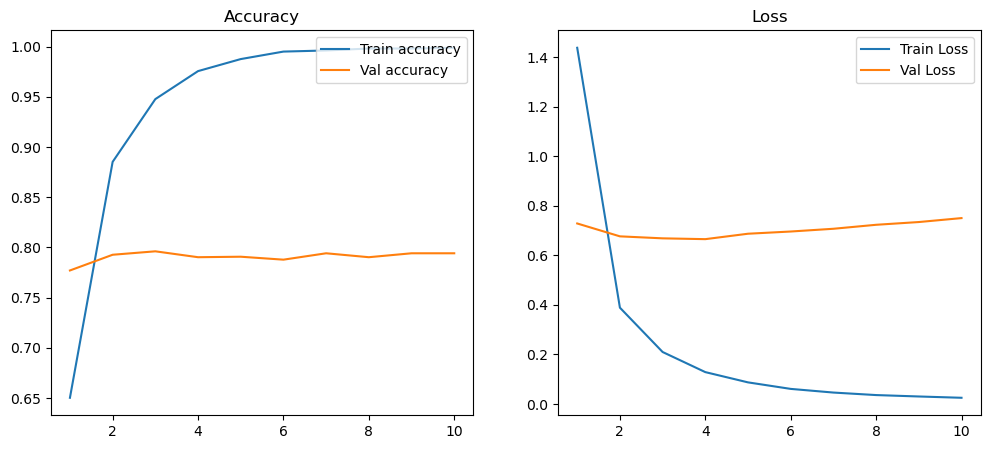

In [ ]:
plot_acurracy(trained_model.history)

#### Save the model

In [ ]:
model.save('models/dog_breed_identification.keras')

In [ ]:
loaded_model = tf_keras.models.load_model("models/dog_breed_identification.keras",custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
def preprocess_prediction_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)
    return image


def predict_dog_breed(image_path):
    processed_image = preprocess_prediction_image(image_path)
    predictions = loaded_model.predict(processed_image)
    predictions = predictions[0]

    predictions_idx = np.argsort(predictions)

    top_5_idx = predictions_idx[-5:][::-1] # Select last 5 predicts and sort by desc
    top_5_breeds = [ unique_breeds[i] for i in top_5_idx ]

    top_5_scores = predictions[top_5_idx]
    top_5_scores = [f"{i * 100:.2f}%"  for i in top_5_scores ]


    final_predictions = pd.DataFrame({"breed":top_5_breeds,"score":top_5_scores})


    return final_predictions


In [ ]:
my_predictions = predict_dog_breed("dog-breed-data/test/8e6a11df866b85cfb0f921b7947ae77d.jpg")

1/1 [==============================] - 0s 20ms/step


In [ ]:
my_predictions

,breed,score
0,english_foxhound,45.18%
1,brittany_spaniel,27.39%
2,walker_hound,25.71%
3,wire-haired_fox_terrier,1.30%
4,toy_terrier,0.15%
